# Imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms,datasets
import torch
import bcolz
import time
%matplotlib inline

In [2]:
import imp
import utils; imp.reload(utils)
from utils import *

GPU test

In [ ]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

In [ ]:
a = torch.tensor(2)
a.cuda()

In [3]:
use_gpu =  False

# Data process

In [6]:
# data_dir = 'D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_Food101\\images'
data_dir = 'data\\UPMC_2\\'

In [7]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'test']}

In [8]:
len(dsets['train'].classes)

2

In [9]:
dsets['train'].class_to_idx

{'apple_pie': 0, 'baby_back_ribs': 1}

In [10]:
dsets['train'].imgs[:5]

[('data\\UPMC_2\\train\\apple_pie\\apple_pie_0.jpg', 0),
 ('data\\UPMC_2\\train\\apple_pie\\apple_pie_100.jpg', 0),
 ('data\\UPMC_2\\train\\apple_pie\\apple_pie_101.jpg', 0),
 ('data\\UPMC_2\\train\\apple_pie\\apple_pie_102.jpg', 0),
 ('data\\UPMC_2\\train\\apple_pie\\apple_pie_104.jpg', 0)]

In [11]:
dset_classes = dsets['train'].classes

In [12]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 1363, 'test': 455}

Dataset loaders

In [13]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=64,
                                               shuffle=shuffle_valtrain(x), num_workers=0)
                for x in ['train', 'test']}

In [14]:
dataset_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=True, num_workers=0)

In [15]:
len(dataset_valid)

91

In [16]:
count = 0
for data in dataset_valid:
    if count == 0:
        inputs_try,labels_try = data
    else:
        break
    count += 1

In [17]:
labels_try

tensor([1, 0, 0, 1, 0])

In [18]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


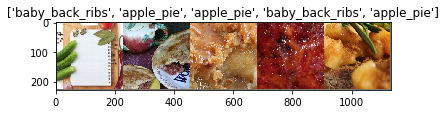

In [19]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


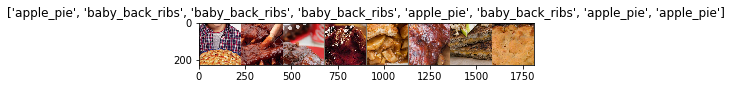

In [20]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


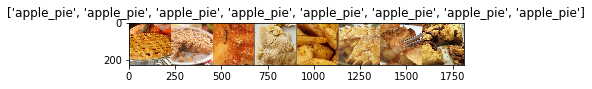

In [21]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['test']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

# Creating VGG Model

In [49]:
model_vgg = models.vgg16(pretrained=True)

In [23]:
inputs_try , labels_try = var_cgpu(inputs_try,use_gpu),var_cgpu(labels_try,use_gpu)

if use_gpu:
    model_vgg = model_vgg.cuda()

In [24]:
outputs_try = model_vgg(inputs_try)

In [25]:
outputs_try

tensor([[ 1.1083,  0.7375, -0.6714,  ...,  1.7992,  7.1473, -0.3555],
        [ 1.7458,  0.9701,  0.2133,  ...,  8.1506,  3.1492,  2.8390],
        [-1.2004,  0.8930, -2.3640,  ...,  2.2515,  4.9690, -0.3032],
        [ 0.9381,  2.4109, -0.9521,  ...,  2.6651,  5.0845, -3.0575],
        [-0.1938,  2.9650, -3.2011,  ...,  5.2003,  7.8234, -1.0767]],
       grad_fn=<AddmmBackward>)

In [26]:
outputs_try.shape

torch.Size([5, 1000])

### Modifying the last layer and setting the gradient false to all layers

In [27]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [50]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)

In [47]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
if use_gpu:
    model_vgg = model_vgg.cuda()

## Calculating preconvoluted features

In [30]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    count = 0
    for data in dataset:
        print(count)
        count += 1
        inputs,labels = data
        if use_gpu:
            inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        else:
            inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [ ]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

In [ ]:
%%time
conv_feat_val,labels_val = preconvfeat(dset_loaders['test'])

### Save extracted features

In [ ]:
save_array(data_dir+'\\vgg16\\conv_feat_train.bc',conv_feat_train)
save_array(data_dir+'\\vgg16\\labels_train.bc',labels_train)
save_array(data_dir+'\\vgg16\\conv_feat_val.bc',conv_feat_val)
save_array(data_dir+'\\vgg16\\labels_val.bc',labels_val)

### Load extracted features

In [31]:
conv_feat_train = load_array(data_dir+'\\vgg16\\conv_feat_train.bc')
labels_train = load_array(data_dir+'\\vgg16\\labels_train.bc')
conv_feat_val = load_array(data_dir+'\\vgg16\\conv_feat_val.bc')
labels_val = load_array(data_dir+'\\vgg16\\labels_val.bc')

## Training fully connected module

### Creating loss function and optimizer

In [51]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Creating Data generator

In [33]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

### Training the model

In [43]:
def train_model(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    loss_history = []
    acc_history = []
    
    if train:
        model.train()
    else:
        model.eval()
        
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            if use_gpu:
                inputs , classes = torch.from_numpy(inputs).cuda(), torch.from_numpy(classes).cuda()
            else:
                inputs , classes = torch.from_numpy(inputs), torch.from_numpy(classes)
                
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
        
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)
        
    return loss_history,acc_history
    

In [52]:
%%time
losses_hist, acc_hist = train_model(model=model_vgg.classifier,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=50,optimizer=optimizer_vgg,train=True,shuffle=True)

Loss: 0.0059 Acc: 0.8232
Loss: 0.0039 Acc: 0.9010
Loss: 0.0036 Acc: 0.9120
Loss: 0.0034 Acc: 0.9142
Loss: 0.0034 Acc: 0.9230
Loss: 0.0031 Acc: 0.9230
Loss: 0.0030 Acc: 0.9281
Loss: 0.0028 Acc: 0.9354
Loss: 0.0028 Acc: 0.9296
Loss: 0.0027 Acc: 0.9362
Loss: 0.0027 Acc: 0.9420
Loss: 0.0027 Acc: 0.9420
Loss: 0.0025 Acc: 0.9391
Loss: 0.0026 Acc: 0.9391
Loss: 0.0024 Acc: 0.9362
Loss: 0.0024 Acc: 0.9464
Loss: 0.0024 Acc: 0.9464
Loss: 0.0027 Acc: 0.9508
Loss: 0.0025 Acc: 0.9464
Loss: 0.0024 Acc: 0.9376
Loss: 0.0024 Acc: 0.9398
Loss: 0.0023 Acc: 0.9464
Loss: 0.0023 Acc: 0.9501
Loss: 0.0022 Acc: 0.9464
Loss: 0.0023 Acc: 0.9428
Loss: 0.0022 Acc: 0.9560
Loss: 0.0023 Acc: 0.9420
Loss: 0.0022 Acc: 0.9464
Loss: 0.0020 Acc: 0.9494
Loss: 0.0023 Acc: 0.9486
Loss: 0.0019 Acc: 0.9567
Loss: 0.0020 Acc: 0.9567
Loss: 0.0021 Acc: 0.9538
Loss: 0.0023 Acc: 0.9472
Loss: 0.0019 Acc: 0.9604
Loss: 0.0021 Acc: 0.9552
Loss: 0.0019 Acc: 0.9560
Loss: 0.0018 Acc: 0.9611
Loss: 0.0018 Acc: 0.9560
Loss: 0.0019 Acc: 0.9545


Validation

In [53]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=model_vgg.classifier
            ,size=dset_sizes['test'],train=False,shuffle=False)

Loss: 0.0029 Acc: 0.9407


([0.0028641681585993084], [0.9406593406593406])

Plot loss & accuracy history

Text(0.5, 1.0, 'Loss history')

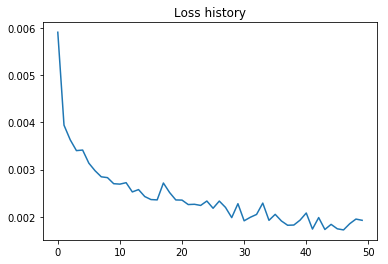

In [54]:
plt.plot(losses_hist)
plt.title("Loss history")

Text(0.5, 1.0, 'Training accuracy history')

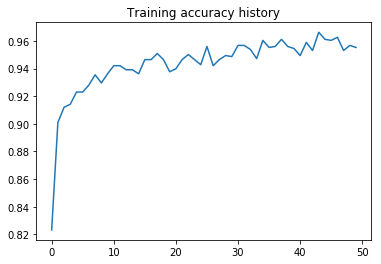

In [56]:
plt.plot(acc_hist)
plt.title("Training accuracy history")

### Some wrong images

In [57]:
m_softm = nn.Softmax(dim=1)

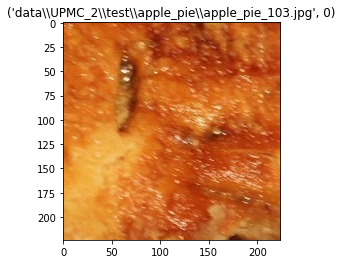

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


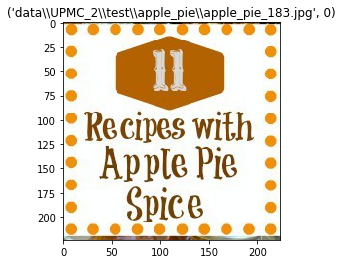

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


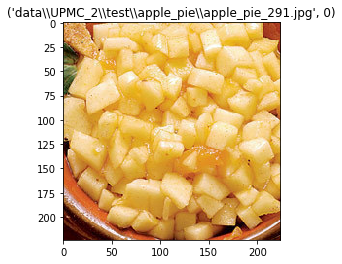

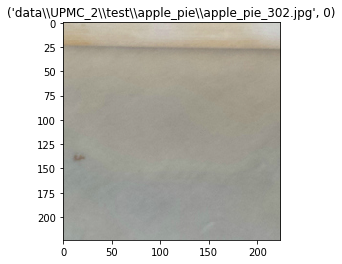

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


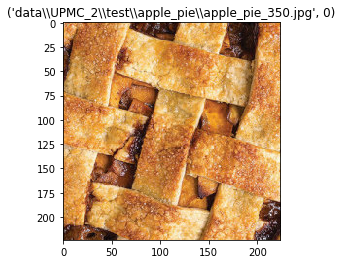

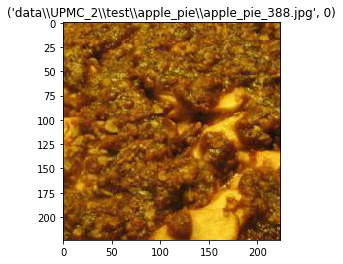

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


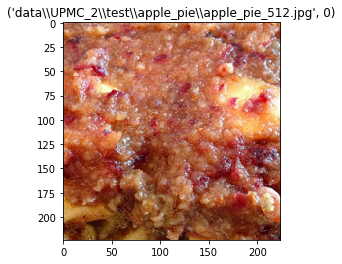

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


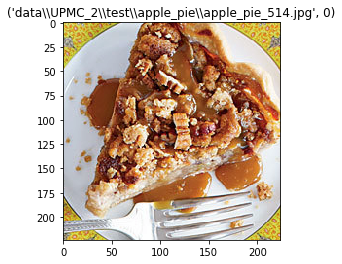

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


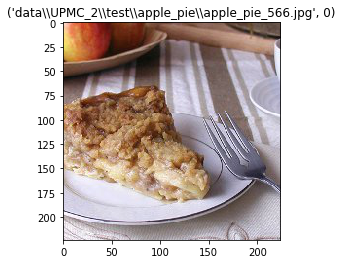

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


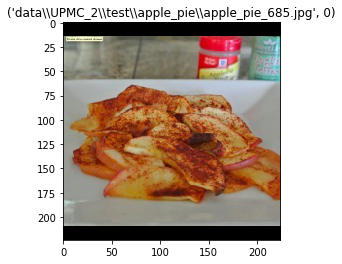

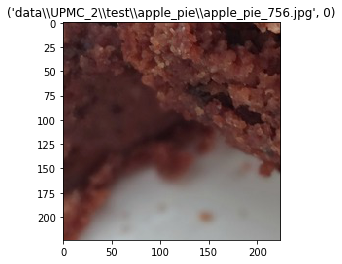

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


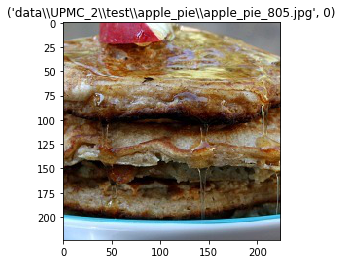

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


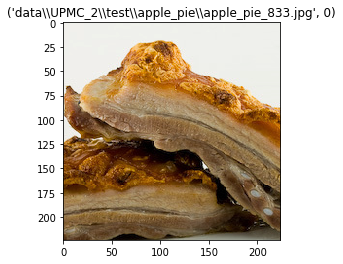

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


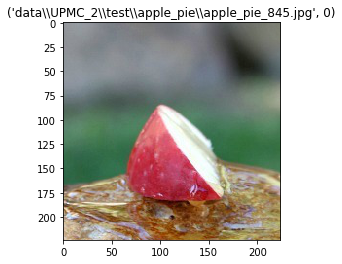

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


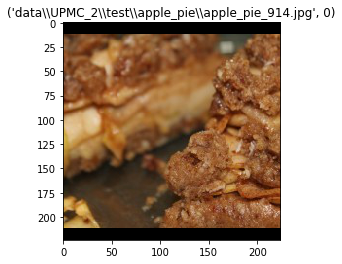

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


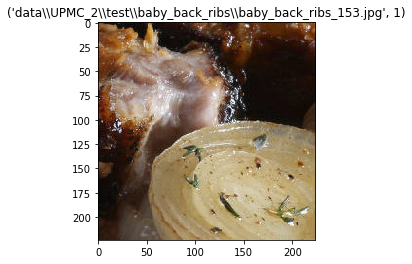

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


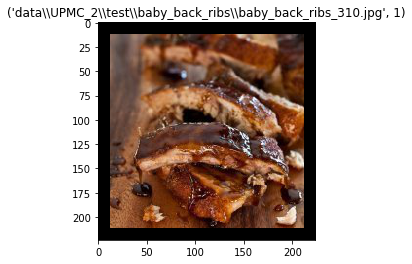

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


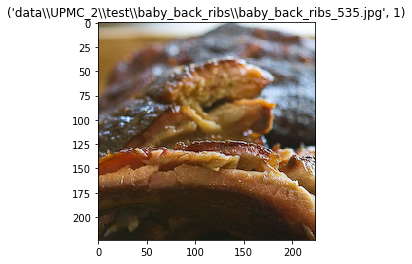

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


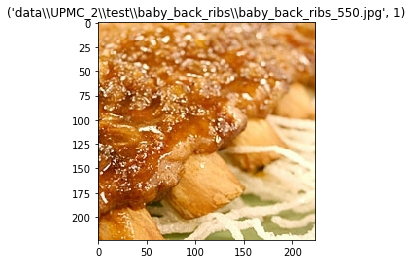

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


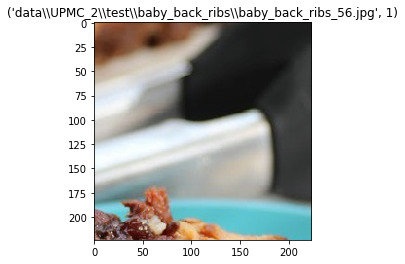

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


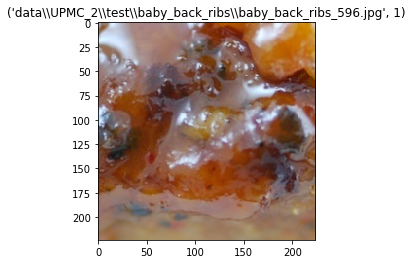

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


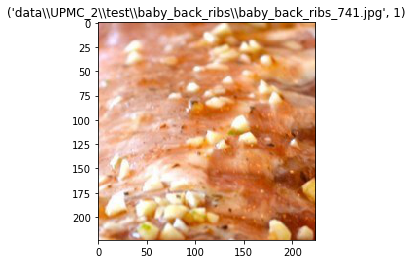

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


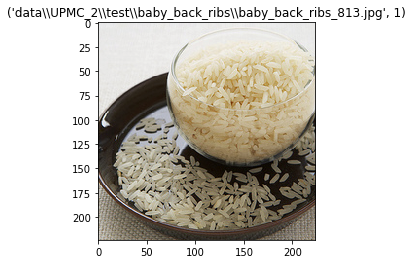

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


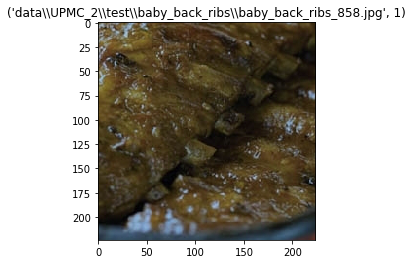

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


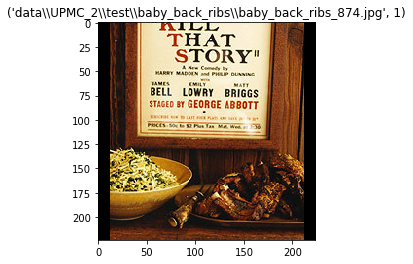

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


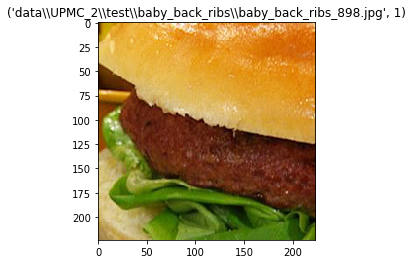

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


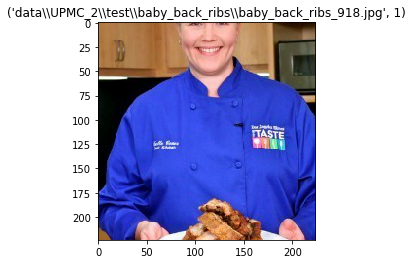

In [68]:
count = 0
test_set_loader = torch.utils.data.DataLoader(dsets['test'], batch_size=dset_sizes['test'],
                                               shuffle=False, num_workers=0)
test_imgs, __ = next(iter(test_set_loader))

for i in range(dset_sizes['test']):
    feat_val = torch.from_numpy(conv_feat_val[i]).view(1,-1)
    label_val = labels_val[i]
    
    _,pred = torch.max(m_softm(model_vgg.classifier(feat_val).data),1)
    
    predicted = pred.data.cpu().numpy()[0]
    
    if predicted != label_val:
        #print(dsets['test'].imgs[i])
        out = torchvision.utils.make_grid(test_imgs[i])
        imshow(out, title=dsets['test'].imgs[i])
        count += 1
    #if count == 20:
    #    break